In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

%matplotlib inline

In [2]:
collisions = pd.read_csv('collisions.csv')

In [3]:
# Collision Data from Open Data Toronto, showing collisions from Jan 2014 to June 2022
# To keep in line with the neighbourhood data available, collisions after 2018 are omitted 
# FTR = Failure to Remain
# PD = Property Damage

collisions = collisions.loc[collisions['Year'] < 2019]
collisions.rename(columns = {'Atom':'Neighbourhood Number'}, inplace = True)

collisions.loc[(collisions['Injury_Collisions'] == 'YES'), 'Injury_Collisions'] = 1
collisions.loc[(collisions['Injury_Collisions'] == 'NO'), 'Injury_Collisions'] = 0

collisions.loc[(collisions['FTR_Collisions'] == 'YES'), 'FTR_Collisions'] = 1
collisions.loc[(collisions['FTR_Collisions'] == 'NO'), 'FTR_Collisions'] = 0

collisions.loc[(collisions['PD_Collisions'] == 'YES'), 'PD_Collisions'] = 1
collisions.loc[(collisions['PD_Collisions'] == 'NO'), 'PD_Collisions'] = 0

collisions['Collision Indicator'] = 1

In [4]:
collisions.dtypes

_id                       int64
EventUniqueId            object
OccurrenceDate           object
Month                    object
Day_of_Week              object
Year                      int64
Hour                    float64
Division                 object
Neighbourhood Number     object
Neighbourhood            object
Fatalities              float64
Injury_Collisions        object
FTR_Collisions           object
PD_Collisions            object
geometry                 object
Collision Indicator       int64
dtype: object

In [5]:
# CSV result of cleaned and manipulated Census data using Excel. Based on 140 neighbourhood model 
# Manipulation included giving scores for % of commutes done by various modes
# The more active the commute to work (order iswalking/cycling, transit, then car), the higher the score
# Commute Duration Score is based on length of commute
# Commute Time Score is based on how late in the day the commute starts
neighbourhoods = pd.read_csv('TOneighbourhoods.csv')
neighbourhoods['Neighbourhood Number'] = neighbourhoods['Neighbourhood Number'].astype(str)

In [6]:
collisions_df =collisions.merge(neighbourhoods,how="inner",on="Neighbourhood Number")

In [7]:
col_ind = collisions_df.groupby(['Neighbourhood Number'])['Collision Indicator'].agg('sum')
col_inj = collisions_df.groupby(['Neighbourhood Number'])['Injury_Collisions'].agg('sum')
col_ftr = collisions_df.groupby(['Neighbourhood Number'])['FTR_Collisions'].agg('sum')
col_pd = collisions_df.groupby(['Neighbourhood Number'])['PD_Collisions'].agg('sum')

In [8]:
col_ind = col_ind.to_frame().reset_index()
col_inj = col_inj.to_frame().reset_index()
col_frt = col_ftr.to_frame().reset_index()
col_pd = col_pd.to_frame().reset_index()

In [9]:
# Merging the collisions and neighbourhoods datasets

neighbourhoods = neighbourhoods.merge(col_ind,how="inner",on="Neighbourhood Number")
neighbourhoods = neighbourhoods.merge(col_inj,how="inner",on="Neighbourhood Number")
neighbourhoods = neighbourhoods.merge(col_ftr,how="inner",on="Neighbourhood Number")
neighbourhoods = neighbourhoods.merge(col_pd,how="inner",on="Neighbourhood Number")

In [10]:
# for better comparions between neighbourhoods, collision rate is per capita
neighbourhoods['Collision Rate'] = (neighbourhoods['Collision Indicator']/neighbourhoods['Population, 2016'])*100
neighbourhoods['Injury_Collisions'] = (neighbourhoods['Injury_Collisions']/neighbourhoods['Collision Indicator'])*100
neighbourhoods['FTR_Collisions'] = (neighbourhoods['FTR_Collisions']/neighbourhoods['Collision Indicator'])*100
neighbourhoods['PD_Collisions'] = (neighbourhoods['PD_Collisions']/neighbourhoods['Collision Indicator'])*100

In [11]:
neighbourhoods.head()

,Neighbourhood,Neighbourhood Number,TSNS2020 Designation,"Population, 2016","Population, 2011",Population Change 2011-2016,Total private dwellings,Population density per square kilometre,Land area in square kilometres,Age Score,...,Bicycle,Bicycle Mode Share,Commute Mode Score,Commute Duration Score,Commute Time Score,Collision Indicator,Injury_Collisions,FTR_Collisions,PD_Collisions,Collision Rate
0,Agincourt North,129,No Designation,29113,30279,-0.039,9371,3929,7.41,2.59,...,70,0.01,1.68,3.03,0.50,2657,17.275122,15.016936,69.025216,9.126507
1,Agincourt South-Malvern West,128,No Designation,23757,21988,0.080,8535,3034,7.83,2.46,...,35,0.00,1.71,3.01,0.58,4523,16.029184,14.879505,70.285209,19.038599
2,Alderwood,20,No Designation,12054,11904,0.013,4732,2435,4.95,2.53,...,65,0.01,1.59,2.70,0.01,845,17.633136,16.331361,68.52071,7.010121
3,Annex,95,No Designation,30526,29177,0.046,18109,10863,2.81,2.50,...,1675,0.11,3.12,2.48,0.84,4932,13.179238,18.126521,70.377129,16.156719
4,Banbury-Don Mills,42,No Designation,27695,26918,0.029,12473,2775,9.98,2.77,...,65,0.01,1.75,2.80,0.41,6194,14.756216,10.881498,75.379399,22.365048


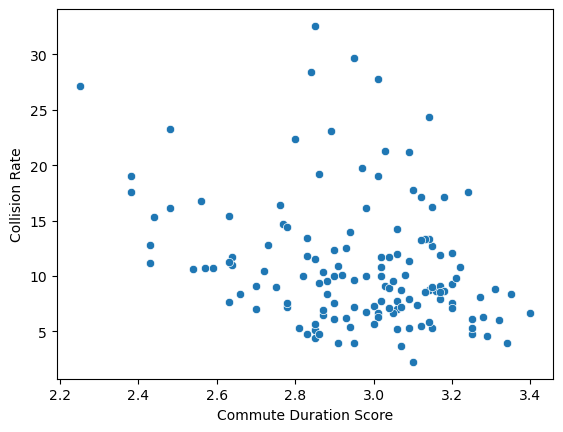

In [12]:
sns.scatterplot(data=neighbourhoods, x='Commute Duration Score', y='Collision Rate')
plt.show()

# Collisions often happen close to one's home so can tie socioeconomic trends to collisions
# Surprisingly, neighbourhoods with shorter commutes generally have higher collisions rates
# the data show only where collisions happen, which may not involve residents of a neighbourhood
# Hence, a limitation to this approach would be downtown Toronto, especially around the highways
# Disclaimer: I live in downtown Toronto and like to think I'm not a menace on the roads

In [13]:
# Creating a correlation matrix to get quick insights on what correlates with collision rate
#Also adding in rates for specific types of collision in this matrix

matrix_df = neighbourhoods[['Population density per square kilometre','Age Score','Commute Mode Score', 'Commute Duration Score', 'Commute Time Score','Collision Rate', 'Injury_Collisions', 'FTR_Collisions', 'PD_Collisions']]

In [14]:
matrix = matrix_df.corr()

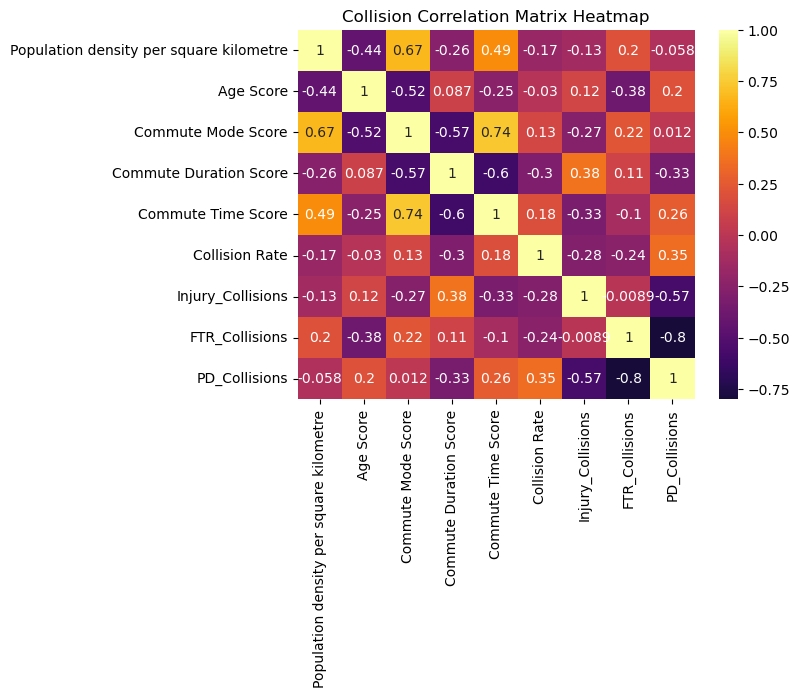

In [15]:
sns.heatmap(matrix, annot=True, cmap='inferno', center=0)

plt.title('Collision Correlation Matrix Heatmap')
plt.show()

In [16]:
# The focus of this analysis will be on the collision rate as a result of neighbourhood metrics 

response = 'Collision Rate'
y = neighbourhoods[[response]]
y

,Collision Rate
0,9.126507
1,19.038599
2,7.010121
3,16.156719
4,22.365048
...,...
135,8.418705
136,16.425489
137,11.222861
138,24.397492


In [17]:
# Critics of density cite more traffic, leading to more collisions. Let's test this. 

predictors = 'Population density per square kilometre'
x_density = neighbourhoods[[predictors]]
x_density

,Population density per square kilometre
0,3929
1,3034
2,2435
3,10863
4,2775
...,...
135,8541
136,7162
137,10708
138,2086


In [18]:
model_density = LinearRegression().fit(x_density, y)

In [19]:
model_density.intercept_

array([12.23638414])

In [20]:
model_density.coef_

array([[-0.0002074]])

In [21]:
model_density.score(x_density, y)

# Slight negative relationship, so more density doesn't mean more collisions. However, low R-squared value)
# Generally each model in the project would be tested 
# As this is an exploratory project, 

0.030074153523906855

In [22]:
# Splitting regresion data to test the model
x__density_train, x_density_test, y_train, y_test = train_test_split(x_density, y, test_size=0.1, random_state = 1234) 

In [23]:
model_density_test = LinearRegression().fit(x__density_train, y_train)

In [24]:
model_density_test.coef_

array([[-0.00021183]])

In [25]:
model_density.score(x_density_test, y_test)

-0.04302765043764123

In [26]:
y_pred = model_density.predict(x_density_test)

In [27]:
mean_absolute_error(y_test, y_pred)
# High error in this model, which is expected given the limitation stated above pertaining to downtown Toronto
# The rest of this project will be considered an exploratory analysis to gain insights into trends
# While some insights can be gained, a predictive model isn't really possible with this

6.3684751218691416

In [28]:
# Now let's look at how an active commute may influence collisions
# Expecting this to be a negative relationship, 
# Howver, as stated above, downtown neighbourhoods experience much more commuter traffic from outside

predictors = 'Commute Mode Score'
x_commute_mode = neighbourhoods[[predictors]]
x_commute_mode

,Commute Mode Score
0,1.68
1,1.71
2,1.59
3,3.12
4,1.75
...,...
135,2.59
136,2.50
137,2.53
138,2.06


In [29]:
model_commute_mode = LinearRegression().fit(x_commute_mode, y)

In [30]:
model_commute_mode.intercept_

array([7.74334174])

In [31]:
model_commute_mode.coef_

array([[1.49784968]])

In [32]:
model_commute_mode.score(x_commute_mode, y)

# Positive relationship between more active commutes and collision rates, but very low R-squared
# Still, watch out pedestrians and cyclists!

0.01650757053658014

In [33]:
# Looking specifically at how public transit usage influences 

predictors = 'Public Transit Mode Share'
x_commute_transit = neighbourhoods[[predictors]]
x_commute_transit

,Public Transit Mode Share
0,0.28
1,0.29
2,0.21
3,0.42
4,0.26
...,...
135,0.46
136,0.49
137,0.50
138,0.42


In [34]:
model_commute_transit = LinearRegression().fit(x_commute_transit, y)

In [35]:
model_commute_transit.intercept_

array([15.75260447])

In [36]:
model_commute_transit.coef_

array([[-12.85409662]])

In [37]:
model_commute_transit.score(x_commute_transit, y)

# Increasing public transit may be more critical to reducing collisions than walking/cycling

0.03696489273418868

In [38]:
# Already have a visualization of how Commute duration impacts collision rate, but let's quantify it

predictors = 'Commute Duration Score'
x_commute_duration = neighbourhoods[[predictors]]
x_commute_duration

,Commute Duration Score
0,3.03
1,3.01
2,2.70
3,2.48
4,2.80
...,...
135,2.88
136,2.76
137,2.63
138,3.14


In [39]:
model_commute_duration = LinearRegression().fit(x_commute_duration, y)

In [40]:
model_commute_duration.intercept_

array([33.10677216])

In [41]:
model_commute_duration.coef_

array([[-7.50145575]])

In [42]:
model_commute_duration.score(x_commute_duration, y)

# Highest R-squared/coefficient of determination
# Note: This is not an endorsement of a longer commute to work. It just means neighbourhoods with residents that commute longer have fewer collisions in their own neighbourhoods

0.08752466661315039

In [43]:
neighbourhoods[['Neighbourhood', 'Collision Rate']].sort_values(by = ['Collision Rate'], ascending = False)

,Neighbourhood,Collision Rate
139,Yorkdale-Glen Park,32.579033
54,Humber Summit,29.647229
93,Old East York,28.452291
128,Wexford/Maryvale,27.750116
6,Bay Street Corridor,27.196961
...,...,...
115,Taylor-Massey,3.985207
56,Humewood-Cedarvale,3.967978
36,Edenbridge-Humber Valley,3.926617
134,Woodbine-Lumsden,3.699936


In [44]:
# A future study can look into specific types of collision, such as those resulting in property damage

neighbourhoods[['Neighbourhood', 'PD_Collisions']].sort_values(by = ['PD_Collisions'], ascending = False)

,Neighbourhood,PD_Collisions
82,Mount Pleasant East,77.145181
111,St.Andrew-Windfields,76.21416
43,Forest Hill North,76.179383
93,Old East York,75.599543
4,Banbury-Don Mills,75.379399
...,...,...
94,Palmerston-Little Italy,60.677083
14,Blake-Jones,60.526316
80,Mount Dennis,60.286029
81,Mount Olive-Silverstone-Jamestown,59.212313
